# Chapter 1 

## Exercise 1

This simple data analysis pipeline uses a [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) model to classify flowers from the famous [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

Questions:

1. Look through the example pipeline. Mark which cells belong to which categories in this categorization:
    - Data perparation and loading
    - Modeling
    - Evaluation
    - Presentation
2. Try to determine the pieces of the code that are **unique** to this specific dataset. Discuss how you would generalize this pipeline to other datasets.

In [228]:
library(tidyverse)
library(broom)
library(modelr)

In [229]:
iris_tbl <- read_csv('../data/iris.data', col_names=c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species')) %>%
    rowid_to_column('id') %>%
    mutate(Species=str_remove(Species, 'Iris-')) %>%
    mutate(Species=as.factor(Species))
print(iris_tbl)

Parsed with column specification:
cols(
  Sepal.Length = col_double(),
  Sepal.Width = col_double(),
  Petal.Length = col_double(),
  Petal.Width = col_double(),
  Species = col_character()
)


# A tibble: 150 x 6
      id Sepal.Length Sepal.Width Petal.Length Petal.Width Species
   <int>        <dbl>       <dbl>        <dbl>       <dbl> <fct>  
 1     1          5.1         3.5          1.4         0.2 setosa 
 2     2          4.9         3            1.4         0.2 setosa 
 3     3          4.7         3.2          1.3         0.2 setosa 
 4     4          4.6         3.1          1.5         0.2 setosa 
 5     5          5           3.6          1.4         0.2 setosa 
 6     6          5.4         3.9          1.7         0.4 setosa 
 7     7          4.6         3.4          1.4         0.3 setosa 
 8     8          5           3.4          1.5         0.2 setosa 
 9     9          4.4         2.9          1.4         0.2 setosa 
10    10          4.9         3.1          1.5         0.1 setosa 
# … with 140 more rows


In [230]:
set.seed(42)
sample_ix <- sample(nrow(iris_tbl))
iris_tbl <- iris_tbl[sample_ix,]
print(iris_tbl)
iris_tbl <- select(iris_tbl, -id)
print(iris_tbl)

# A tibble: 150 x 6
      id Sepal.Length Sepal.Width Petal.Length Petal.Width Species   
   <int>        <dbl>       <dbl>        <dbl>       <dbl> <fct>     
 1    49          5.3         3.7          1.5         0.2 setosa    
 2    65          5.6         2.9          3.6         1.3 versicolor
 3    74          6.1         2.8          4.7         1.2 versicolor
 4   146          6.7         3            5.2         2.3 virginica 
 5   122          5.6         2.8          4.9         2   virginica 
 6   150          5.9         3            5.1         1.8 virginica 
 7   128          6.1         3            4.9         1.8 virginica 
 8    47          5.1         3.8          1.6         0.2 setosa    
 9    24          5.1         3.3          1.7         0.5 setosa    
10    71          5.9         3.2          4.8         1.8 versicolor
# … with 140 more rows
# A tibble: 150 x 5
   Sepal.Length Sepal.Width Petal.Length Petal.Width Species   
          <dbl>       <dbl>      

In [231]:
iris_split <- iris_tbl %>%
    resample_partition(c(train=0.8, test=0.2))
head(iris_split)

$train
<resample [119 x 5]> 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, ...

$test
<resample [31 x 5]> 3, 5, 15, 16, 24, 29, 32, 46, 49, 55, ...


In [232]:
iris_split$train %>%
    as_tibble() %>%
    group_by(Species) %>%
    tally()

iris_split$test %>%
    as_tibble() %>%
    group_by(Species) %>%
    tally()

Species,n
setosa,38
versicolor,40
virginica,41


Species,n
setosa,12
versicolor,10
virginica,9


In [233]:
library(rpart)

In [243]:
fitted_tree <- iris_split$train %>%
    as_tibble() %>%
#    select(-Species) %>%
#    rpart(species_id ~ ., data=.)
    rpart(Species ~ ., data=., method='class')

In [244]:
iris_fitted <- iris_split$test %>%
    as_tibble() %>%
    mutate(Prediction = predict(fitted_tree, newdata=., type='class'))
    #mutate(prediction_species = as.factor(prediction, levels=Species.levels))

In [245]:
head(iris_fitted)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,Prediction
"6,1","2,8","4,7","1,2",versicolor,versicolor
"5,6","2,8","4,9","2,0",virginica,virginica
"5,7","2,5","5,0","2,0",virginica,virginica
"6,5","3,2","5,1","2,0",virginica,virginica
"5,5","4,2","1,4","0,2",setosa,setosa
"5,7","2,9","4,2","1,3",versicolor,versicolor


In [246]:
fitted_tree

n= 119 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 119 78 virginica (0,31932773 0,33613445 0,34453782)  
  2) Petal.Length< 2,45 38  0 setosa (1,00000000 0,00000000 0,00000000) *
  3) Petal.Length>=2,45 81 40 virginica (0,00000000 0,49382716 0,50617284)  
    6) Petal.Width< 1,75 43  4 versicolor (0,00000000 0,90697674 0,09302326) *
    7) Petal.Width>=1,75 38  1 virginica (0,00000000 0,02631579 0,97368421) *

In [247]:
library(caret)

In [248]:
confusionMatrix(iris_fitted$Species, iris_fitted$Prediction)

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         10         0
  virginica       0          1         8

Overall Statistics
                                         
               Accuracy : 0,9677         
                 95% CI : (0,833, 0,9992)
    No Information Rate : 0,3871         
    P-Value [Acc > NIR] : 8,358e-12      
                                         
                  Kappa : 0,9512         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1,0000            0,9091           1,0000
Specificity                 1,0000            1,0000           0,9565
Pos Pred Value              1,0000            1,0000           0,8889
Neg Pred Value              1,0000            0,9524           1,0000
Prevalence

In [240]:
iris_fitted <- iris_fitted %>%
    mutate(tree_failure=Species != Prediction)

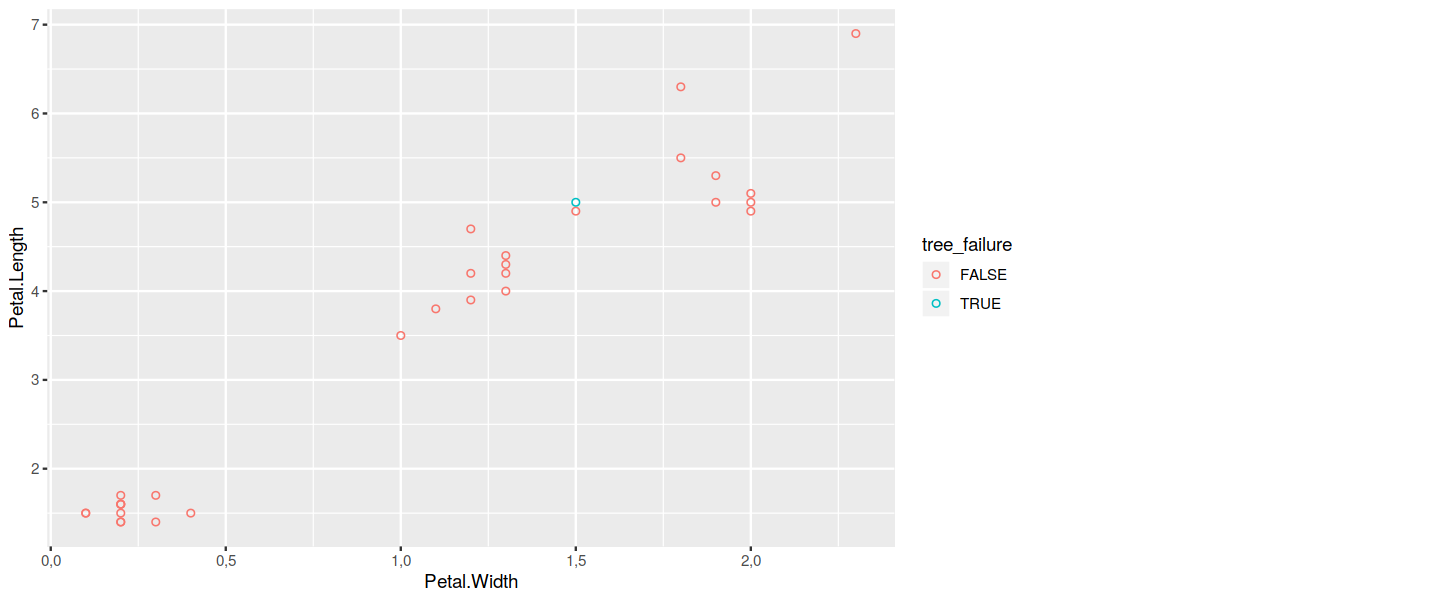

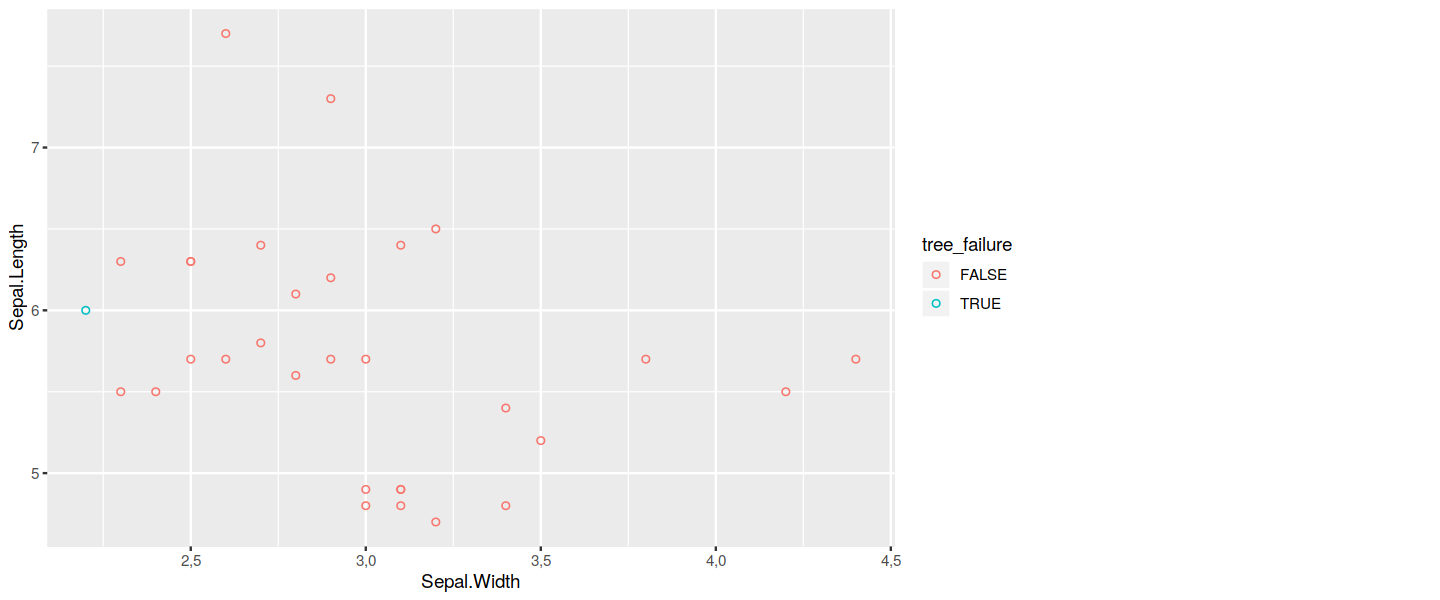

In [241]:
options(repr.plot.width=12, repr.plot.height=5)
iris_fitted %>%
    ggplot(aes(x=Petal.Width, y=Petal.Length, color=tree_failure)) +
        geom_point(shape=1)
iris_fitted %>%
    ggplot(aes(x=Sepal.Width, y=Sepal.Length, color=tree_failure)) +
        geom_point(shape=1)